In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow --quiet

In [ ]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [ ]:
# Read in the Platinum dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Platinum_Data.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

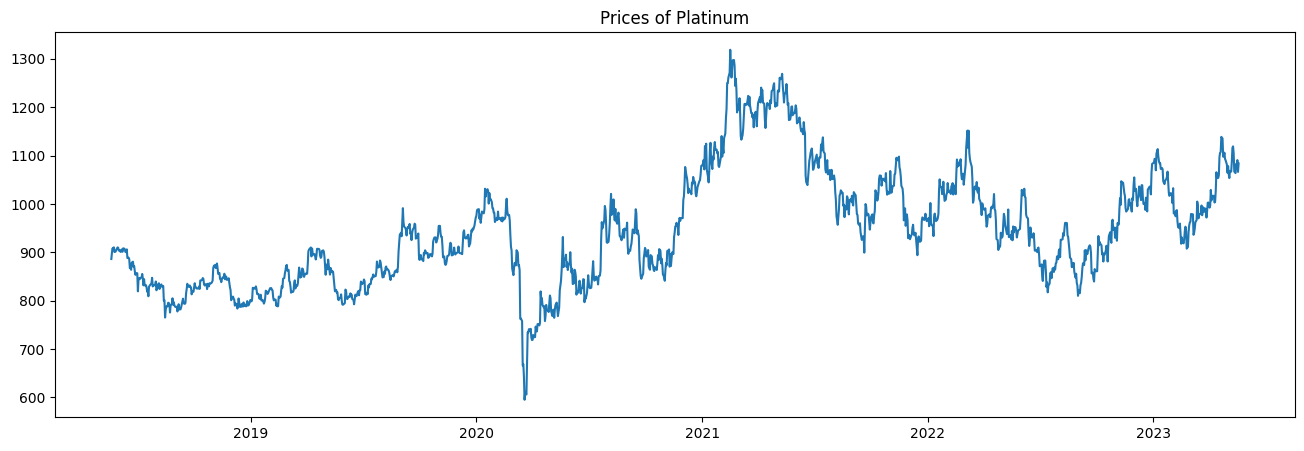

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Platinum')
plt.show()

# Split dataset (7-2-1)

---



In [ ]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

# Split the data (7-2-1)
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(7-2-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.18168, saving model to save_model(7-2-1).hdf5
22/22 - 1s - loss: 0.1817 - 1s/epoch - 63ms/step
Epoch 2/80

Epoch 2: loss improved from 0.18168 to 0.05544, saving model to save_model(7-2-1).hdf5
22/22 - 0s - loss: 0.0554 - 96ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 0.05544 to 0.03233, saving model to save_model(7-2-1).hdf5
22/22 - 0s - loss: 0.0323 - 140ms/epoch - 6ms/step
Epoch 4/80

Epoch 4: loss improved from 0.03233 to 0.02869, saving model to save_model(7-2-1).hdf5
22/22 - 0s - loss: 0.0287 - 118ms/epoch - 5ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02869 to 0.02570, saving model to save_model(7-2-1).hdf5
22/22 - 0s - loss: 0.0257 - 125ms/epoch - 6ms/step
Epoch 6/80

Epoch 6: loss improved from 0.02570 to 0.02436, saving model to save_model(7-2-1).hdf5
22/22 - 0s - loss: 0.0244 - 105ms/epoch - 5ms/step
Epoch 7/80

Epoch 7: loss did not improve from 0.02436
22/22 - 0s - loss: 0.0245 - 90ms/epoch - 4ms/step
Ep

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(7-2-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

34/34 [==============================] - 0s 3ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

10/10 [==============================] - 0s 3ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 3ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        print(x_input.shape)
        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
(1, 5, 1)
[[0.677436113357544], [0.6807446479797363], [0.6853232979774475], [0.6872543096542358], [0.6905748844146729], [0.6937112212181091], [0.696868360042572], [0.7001307010650635], [0.7033111453056335], [0.7065056562423706], [0.7096936106681824], [0.7128769755363464], [0.7160631418228149], [0.7192460298538208], [0.72242671251297], [0.7256045341491699], [0.7287787795066833], [0.7319493293762207], [0.7351158261299133], [0.7382778525352478], [0.7414351105690002], [0.7445871829986572], [0.7477335929870605], [0.7508741021156311], [0.7540081739425659], [0.7571353912353516], [0.7602553963661194], [0.7633680105209351], [0.7664724588394165], [0.769568681716919]]


In [ ]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

<Figure size 1600x500 with 0 Axes>

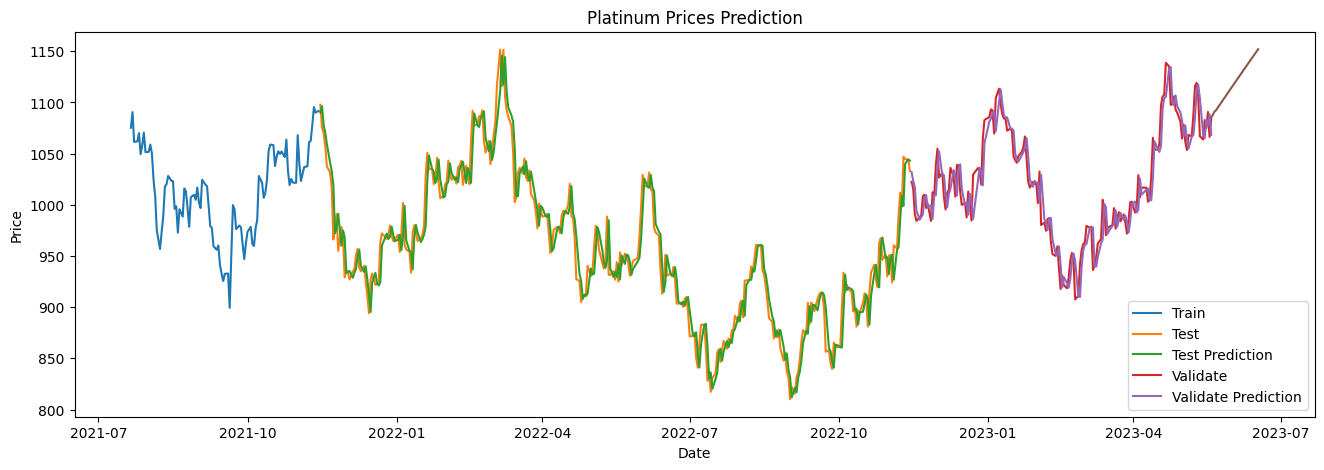

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Platinum Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  13.811731624296627
MAPE:  1.4436379239813826
RMSE:  17.948344592550523

** Validate **
MAE:  13.379317556976513
MAPE:  1.3099994802829977
RMSE:  17.36845269293946


# Split dataset (6-3-1)

---



In [ ]:
# Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(6-3-1).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.08303, saving model to save_model(6-3-1).hdf5
19/19 - 1s - loss: 0.0830 - 1s/epoch - 59ms/step
Epoch 2/80

Epoch 2: loss improved from 0.08303 to 0.03259, saving model to save_model(6-3-1).hdf5
19/19 - 0s - loss: 0.0326 - 85ms/epoch - 4ms/step
Epoch 3/80

Epoch 3: loss improved from 0.03259 to 0.02521, saving model to save_model(6-3-1).hdf5
19/19 - 0s - loss: 0.0252 - 65ms/epoch - 3ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02521 to 0.02374, saving model to save_model(6-3-1).hdf5
19/19 - 0s - loss: 0.0237 - 86ms/epoch - 5ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02374 to 0.02148, saving model to save_model(6-3-1).hdf5
19/19 - 0s - loss: 0.0215 - 96ms/epoch - 5ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.02148
19/19 - 0s - loss: 0.0218 - 73ms/epoch - 4ms/step
Epoch 7/80

Epoch 7: loss improved from 0.02148 to 0.02089, saving model to save_model(6-3-1).hdf5
19/19 - 0s - loss: 0.0209 - 107ms/epoch - 6ms/step
Epoch

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(6-3-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

30/30 [==============================] - 0s 3ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

15/15 [==============================] - 0s 3ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 3ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.6767922043800354], [0.679523766040802], [0.6832377314567566], [0.6851542592048645], [0.6879071593284607], [0.690544843673706], [0.6931792497634888], [0.695862889289856], [0.698513925075531], [0.7011671662330627], [0.7038153409957886], [0.7064579129219055], [0.7090970277786255], [0.7117313146591187], [0.7143604159355164], [0.7169845104217529], [0.7196031212806702], [0.7222161889076233], [0.7248233556747437], [0.727424144744873], [0.730018675327301], [0.7326063513755798], [0.7351869344711304], [0.7377605438232422], [0.7403265833854675], [0.7428848147392273], [0.7454352378845215], [0.7479772567749023], [0.7505110502243042], [0.7530360817909241]]


<Figure size 1600x500 with 0 Axes>

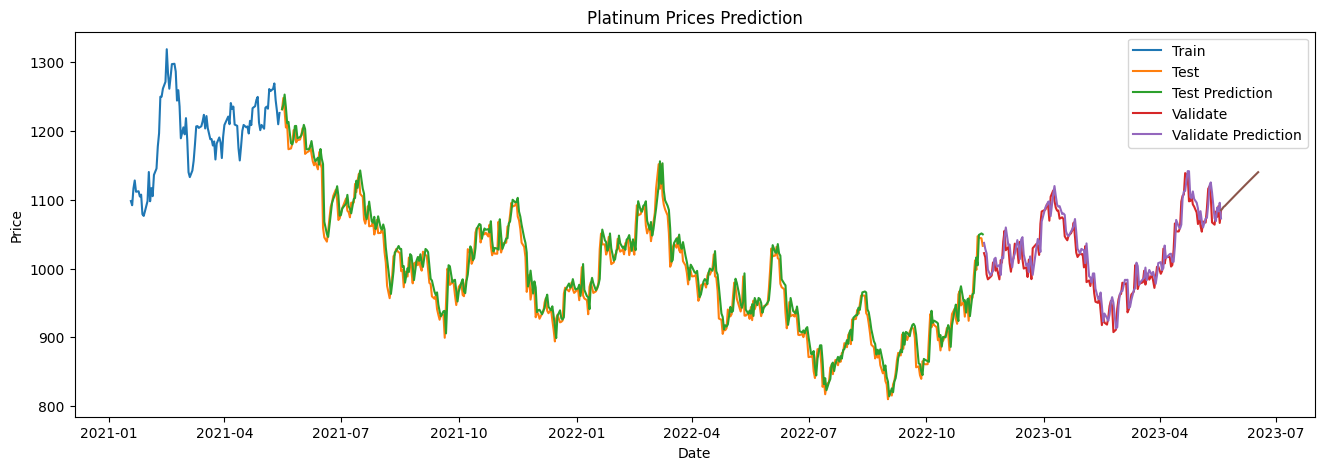

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Platinum Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  14.522113755938841
MAPE:  1.4789347064948373
RMSE:  18.909147255446477

** Validate **
MAE:  14.186715328921181
MAPE:  1.3921272372348104
RMSE:  18.204014000656194


# Split dataset (5-3-2)

---



In [ ]:
# Split data (5-3-2)
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(5, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')

save_model = 'save_model(5-3-2).hdf5'

best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.16179, saving model to save_model(5-3-2).hdf5
16/16 - 4s - loss: 0.1618 - 4s/epoch - 225ms/step
Epoch 2/80

Epoch 2: loss improved from 0.16179 to 0.05056, saving model to save_model(5-3-2).hdf5
16/16 - 0s - loss: 0.0506 - 99ms/epoch - 6ms/step
Epoch 3/80

Epoch 3: loss improved from 0.05056 to 0.03901, saving model to save_model(5-3-2).hdf5
16/16 - 0s - loss: 0.0390 - 106ms/epoch - 7ms/step
Epoch 4/80

Epoch 4: loss improved from 0.03901 to 0.03550, saving model to save_model(5-3-2).hdf5
16/16 - 0s - loss: 0.0355 - 93ms/epoch - 6ms/step
Epoch 5/80

Epoch 5: loss improved from 0.03550 to 0.03274, saving model to save_model(5-3-2).hdf5
16/16 - 0s - loss: 0.0327 - 91ms/epoch - 6ms/step
Epoch 6/80

Epoch 6: loss improved from 0.03274 to 0.03073, saving model to save_model(5-3-2).hdf5
16/16 - 0s - loss: 0.0307 - 159ms/epoch - 10ms/step
Epoch 7/80

Epoch 7: loss improved from 0.03073 to 0.02803, saving model to save_model(5-3-2).hdf5
16/16 - 

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(5-3-2).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

25/25 [==============================] - 0s 2ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

15/15 [==============================] - 0s 2ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

10/10 [==============================] - 0s 2ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.664564311504364], [0.6573929190635681], [0.6499654054641724], [0.6427679657936096], [0.6355283260345459], [0.6286758780479431], [0.6221131682395935], [0.6158413887023926], [0.6098467707633972], [0.6041151881217957], [0.5986289978027344], [0.5933732390403748], [0.5883335471153259], [0.5834967494010925], [0.578851044178009], [0.5743850469589233], [0.5700883865356445], [0.565951943397522], [0.5619667768478394], [0.5581247210502625], [0.5544183850288391], [0.5508406162261963], [0.5473851561546326], [0.5440456867218018], [0.540816605091095], [0.537692666053772], [0.5346689224243164], [0.5317409038543701], [0.5289039015769958], [0.5261542201042175]]


<Figure size 1600x500 with 0 Axes>

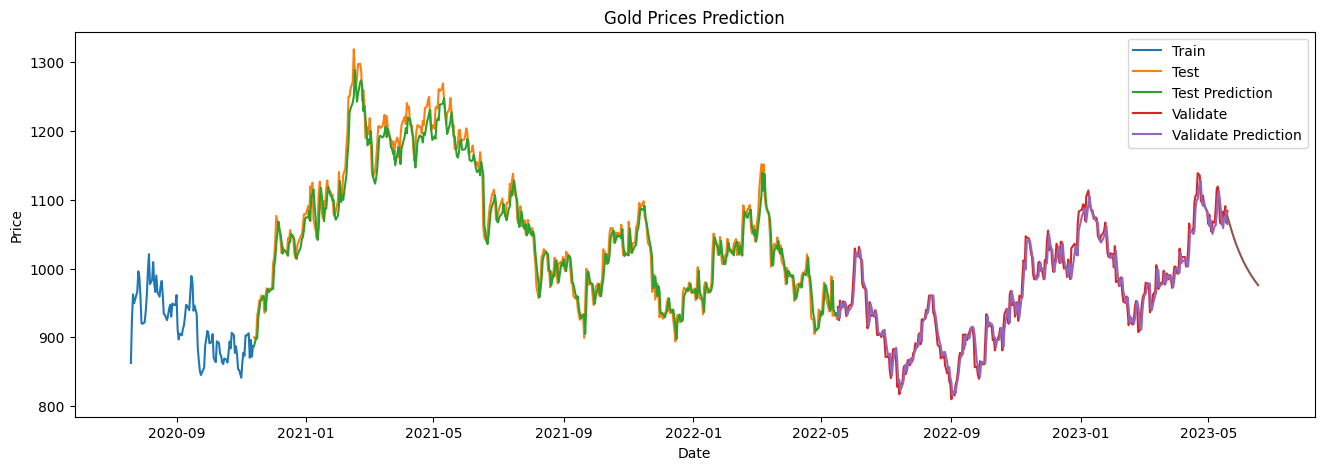

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Platinum Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  15.841778629801262
MAPE:  1.4755188706485618
RMSE:  20.42467668970057

** Validate **
MAE:  13.26136987148187
MAPE:  1.373982749959227
RMSE:  17.13186083881801


# Evaluate Model

---
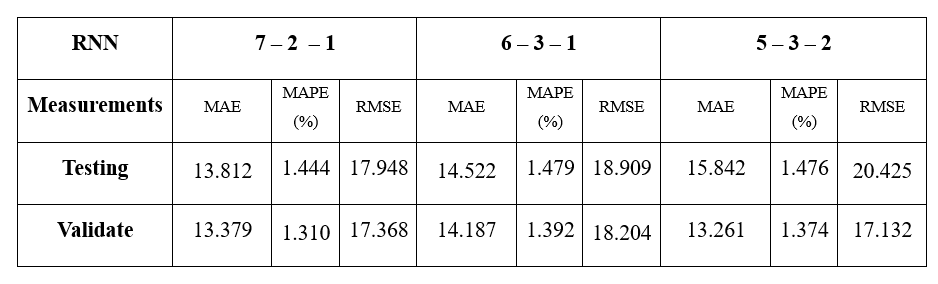